In [ ]:
# q=[]
# while True:
#   q.append(1)

# https://towardsdatascience.com/semantic-code-search-3cd6d244a39c
# https://towardsdatascience.com/how-to-create-data-products-that-are-magical-using-sequence-to-sequence-models-703f86a231f8

Objective: To build a search engine based on StackOverflow questions and search result should include semantic meaning

Dataset: https://meta.stackexchange.com/questions/138356/how-do-i-download-stack-overflows-data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import os
import sys
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Embedding, Input, LSTM, BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, SGD
import re

import tensorflow.keras.backend as K

In [ ]:
import pandas as pd
df1=pd.read_csv(r'/content/drive/My Drive/casestudy1/datascience_Question_with_Ans.csv',encoding='latin1')
df2=pd.read_csv(r'/content/drive/My Drive/casestudy1/Fitness_Question_with_Ans.csv')


In [ ]:
df1=df1.head(10000)
df2=df2.head(8000)

In [ ]:
Questions=df1.append(df2)

print(df1.shape)
print(df2.shape)
print(Questions.shape)

(10000, 13)
(8000, 13)
(18000, 13)


In [ ]:
Questions.reset_index(inplace=True)

In [ ]:

df2.head(2)

df1.head(2)

Questions.head(2)

,level_0,Unnamed: 0,index,_Id,_PostTypeId,_AcceptedAnswerId,_Score,_ViewCount,_Body,_Title,_Tags,_AnswerCount,Ans,Title+Body+Ans
0,0,0,0,5.0,1.0,NaN,8.0,643.0,<p>I've always been interested in machine lear...,How can I do simple machine learning without h...,<machine-learning>,1.0,"<p>Not sure if this fits the scope of this SE,...",How can I do simple machine learning without h...
1,1,1,1,7.0,1.0,10.0,4.0,429.0,"<p>As a researcher and instructor, I'm looking...",What open-source books (or other materials) pr...,<education><open-source>,3.0,"<p>One book that's freely available is ""The El...",What open-source books (or other materials) pr...


Text Preprocessing

In [ ]:
# https://stackoverflow.com/questions/9662346/python-code-to-remove-html-tags-from-a-string

def cleancode(question):
  code = str(re.findall(r'<code>(.*?)</code>', question, flags=re.DOTALL))
  # print(code)
  # print("******************************")
  question=re.sub('<code>(.*?)</code>', '', question, flags=re.MULTILINE|re.DOTALL)
  # print(question)
  return question

# it removes the html tags
def cleanhtml(raw_html):
    cleanr = re.compile('<.*?>') 
    cleantext = re.sub(cleanr, '', raw_html)
    cleanr = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    cleantext = re.sub(cleanr, '', cleantext)
    return cleantext.lower()

# it removes the urls 
def cleanurls(x):
    result = re.sub(r"http\S+", "", x)
    return result

from nltk.corpus import stopwords

stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you',
"you're", "you've","you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he',
'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they',
'them', 'their','theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those',
'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 
'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 
'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into','through', 'during', 'before', 'after',
'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',
'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',
'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very',
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're',
've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn',"didn't", 'doesn', "doesn't", 'hadn',
"hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 
'won', "won't", 'wouldn', "wouldn't"]

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase


def col_decontracted(col):
    clean_Title_Body_Ans = []
    for titles in Questions[col].values:
        title = decontracted(titles)
        title = title.replace('\\r', ' ')
        title = title.replace('\\"', ' ')
        title = title.replace('\\n', ' ')
        title = re.sub('[^A-Za-z0-9]+', ' ', title)
        title = ' '.join(f for f in title.split() if f not in stopwords)
        clean_Title_Body_Ans.append(title.lower().strip())
    return clean_Title_Body_Ans



In [ ]:
Questions['clean_Title_Body_Ans']=Questions['Title+Body+Ans'].apply(lambda x: cleanhtml(x))
Questions['clean_Title_Body_Ans']=Questions['clean_Title_Body_Ans'].apply(lambda x: cleanurls(x))
Questions['clean_Title_Body_Ans'] =col_decontracted("clean_Title_Body_Ans")

In [ ]:
Questions['clean_Title']=Questions['_Title'].apply(lambda x: cleanhtml(x))
Questions['clean_Title']=Questions['clean_Title'].apply(lambda x: cleanurls(x))
Questions['clean_Title'] =col_decontracted("clean_Title")

In [ ]:
Questions['~code_Body']=Questions['_Body'].apply(lambda x: cleancode(x))
Questions['clean_Body']=Questions['~code_Body'].apply(lambda x: cleanhtml(x))

# Questions['clean_Body']=Questions['_Body'].apply(lambda x: cleanhtml(x))
Questions['clean_Body']=Questions['clean_Body'].apply(lambda x: cleanurls(x))
Questions['clean_Body'] =col_decontracted("clean_Body")

In [ ]:
Questions.head(1)

,level_0,Unnamed: 0,index,_Id,_PostTypeId,_AcceptedAnswerId,_Score,_ViewCount,_Body,_Title,_Tags,_AnswerCount,Ans,Title+Body+Ans,clean_Title_Body_Ans,clean_Title,~code_Body,clean_Body
0,0,0,0,5.0,1.0,NaN,8.0,643.0,<p>I've always been interested in machine lear...,How can I do simple machine learning without h...,<machine-learning>,1.0,"<p>Not sure if this fits the scope of this SE,...",How can I do simple machine learning without h...,simple machine learning without hard coding be...,simple machine learning without hard coding be...,<p>I've always been interested in machine lear...,always interested machine learning not figure ...


In [ ]:
# taking only cleaned title and clean questions and actual questions
df=Questions[['clean_Title','clean_Body','_Body']]

In [ ]:
# df=df.head(100)

In [ ]:
df=df.head(1000)

In [ ]:
df.shape

(1000, 3)

In [ ]:
# configurations 
batch_size = 512 
encode_dim = 50  
# max_num_words = 10000
embedding_dim = 300

In [ ]:
input_texts = []
target_texts = [] 
target_texts_inputs = []

In [ ]:
# taking each element into list
for i in range(len(df)):
  input_texts.append(df['clean_Body'].iloc[i])
  target_texts.append(df['clean_Title'].iloc[i]+' >')
  target_texts_inputs.append('< '+df['clean_Title'].iloc[i])


In [ ]:
print(target_texts_inputs[0])
target_texts[0]

< simple machine learning without hard coding behavior


'simple machine learning without hard coding behavior >'

In [ ]:
print(f' Input:{input_texts[0]} - Target :{target_texts[0]} -  Target Input :{target_texts_inputs[0]}')

 Input:always interested machine learning not figure one thing starting simple hello world example avoid hard coding behavior example wanted teach bot avoid randomly placed obstacles could not use relative motion obstacles move around not want hard code say distance ruins whole point machine learning obviously randomly generating code would impractical could - Target :simple machine learning without hard coding behavior > -  Target Input :< simple machine learning without hard coding behavior


In [ ]:
# from keras.preprocessing.text import Tokenizer
# # define 5 documents
# docs = ['work done Well!',
# 		'work Good work done',
# 		'Great work effort',
# 		'nice work',
# 		'Excellent!']
# # create the tokenizer
# t = Tokenizer(num_words=4)
# # fit the tokenizer on the documents
# t.fit_on_texts(docs)
# # summarize what was learned
# # print(t.word_counts)
# print(t.document_count)
# print(t.word_index)
# # print(t.word_docs)
# # integer encode documents
# encoded_docs = t.texts_to_matrix(docs, mode='count')
# # print(encoded_docs)

# texts_to_sequences1=t.texts_to_sequences(docs)
# print(texts_to_sequences1)

In [ ]:
#tokenizing the inputs
tokenizer_inputs = Tokenizer(num_words=None, char_level=True)# max_num_words
tokenizer_inputs.fit_on_texts(input_texts)
input_sequences = tokenizer_inputs.texts_to_sequences(input_texts)

In [ ]:
# max_num_words

In [ ]:
len(input_sequences[0])

353

In [ ]:
tokenizer_inputs.word_index

{' ': 1,
 '0': 25,
 '1': 26,
 '2': 28,
 '3': 31,
 '4': 33,
 '5': 32,
 '6': 35,
 '7': 34,
 '8': 37,
 '9': 36,
 'a': 4,
 'b': 20,
 'c': 11,
 'd': 12,
 'e': 2,
 'f': 18,
 'g': 16,
 'h': 17,
 'i': 5,
 'j': 30,
 'k': 23,
 'l': 10,
 'm': 14,
 'n': 7,
 'o': 9,
 'p': 15,
 'q': 27,
 'r': 8,
 's': 6,
 't': 3,
 'u': 13,
 'v': 22,
 'w': 21,
 'x': 24,
 'y': 19,
 'z': 29}

In [ ]:
# mapping unique word to unique index
word_2_index_inputs = tokenizer_inputs.word_index
print('Found %s unique input tokens.' % len(word_2_index_inputs))

Found 37 unique input tokens.


In [ ]:
# highest no of words in input sentence
max_len_input = max(len(s) for s in input_sequences)
max_len_input

7975

In [ ]:
arr=[]
for i in input_sequences:
  arr.append(len(i))
# s=s/len(input_sequences)
arr.sort(reverse=True)
len(arr)

1000

In [ ]:
arr[0:10]

[7975, 3841, 2817, 2597, 2417, 2407, 2405, 2153, 2141, 2132]

In [ ]:
#tokenizing the outputs
tokenizer_outputs = Tokenizer(num_words=None, char_level=True, filters='')
tokenizer_outputs.fit_on_texts(target_texts + target_texts_inputs)
target_sequences = tokenizer_outputs.texts_to_sequences(target_texts)
target_sequences_inputs = tokenizer_outputs.texts_to_sequences(target_texts_inputs)

In [ ]:
len(target_sequences_inputs[0])

54

In [ ]:
word_2_index_outputs = tokenizer_outputs.word_index
print('Found %s unique output tokens.' % len(word_2_index_outputs))

Found 38 unique output tokens.


In [ ]:
word_2_index_outputs

{' ': 1,
 '0': 31,
 '1': 32,
 '2': 30,
 '3': 33,
 '4': 34,
 '5': 35,
 '6': 36,
 '7': 38,
 '8': 37,
 '<': 20,
 '>': 19,
 'a': 3,
 'b': 21,
 'c': 11,
 'd': 12,
 'e': 2,
 'f': 18,
 'g': 13,
 'h': 17,
 'i': 4,
 'j': 29,
 'k': 24,
 'l': 10,
 'm': 14,
 'n': 6,
 'o': 9,
 'p': 15,
 'q': 28,
 'r': 8,
 's': 7,
 't': 5,
 'u': 16,
 'v': 23,
 'w': 25,
 'x': 26,
 'y': 22,
 'z': 27}

In [ ]:
num_words_output = len(word_2_index_outputs) + 1

In [ ]:
# highest no of words in output sentence
max_len_target = max(len(s) for s in target_sequences)
max_len_target

120

In [ ]:
arr=[]
for i in target_sequences:
  arr.append(len(i))
# s=s/len(input_sequences)
arr.sort(reverse=True)
len(arr)

1000

In [ ]:
arr[0:10]

[120, 115, 104, 102, 98, 97, 95, 93, 92, 90]

In [ ]:
#padding for encoder inputs
encoder_inputs = pad_sequences(input_sequences, maxlen=4000)
print("encoder_inputs.shape:", encoder_inputs.shape)
print("encoder_inputs[0]:", encoder_inputs[0])

encoder_inputs.shape: (1000, 4000)
encoder_inputs[0]: [ 0  0  0 ... 13 10 12]


In [ ]:
#padding for decoder input
decoder_inputs = pad_sequences(target_sequences_inputs, maxlen=max_len_target, padding='post')
print("decoder_inputs[0]:", decoder_inputs[0])
print("decoder_inputs.shape:", decoder_inputs.shape)

decoder_inputs[0]: [20  1  7  4 14 15 10  2  1 14  3 11 17  4  6  2  1 10  2  3  8  6  4  6
 13  1 25  4  5 17  9 16  5  1 17  3  8 12  1 11  9 12  4  6 13  1 21  2
 17  3 23  4  9  8  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
decoder_inputs.shape: (1000, 120)


In [ ]:
#padding for decoder target
decoder_targets = pad_sequences(target_sequences, maxlen=max_len_target, padding='post')
print("decoder_targets[0]:", decoder_targets[0])
print("decoder_targets.shape:", decoder_targets.shape)

decoder_targets[0]: [ 7  4 14 15 10  2  1 14  3 11 17  4  6  2  1 10  2  3  8  6  4  6 13  1
 25  4  5 17  9 16  5  1 17  3  8 12  1 11  9 12  4  6 13  1 21  2 17  3
 23  4  9  8  1 19  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
decoder_targets.shape: (1000, 120)


In [ ]:
import os
print('Loading word vectors...')
word2vec = {}
with open(os.path.join('/content/drive/My Drive/casestudy1/glove.840B.%sd-char.txt' % embedding_dim), encoding='utf8') as f: # glove.6B.%sd.txt
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Loading word vectors...
Found 94 word vectors.


In [ ]:
len(word_2_index_inputs)

37

In [ ]:
# import numpy as np
# objects_one_hot = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], 
#      [0, 0 , 0, 1], [1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0]]) 
# print(objects_one_hot.shape)
# M = np.array([[1, 1], [1, 2], [2, 2], [3,3]])
# print(M.shape)
# objects_one_hot.dot(M).shape

In [ ]:
num_words = len(word_2_index_inputs) + 1 #min(max_num_words, len(word_2_index_inputs) + 1)
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_2_index_inputs.items():
    if i < num_words:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [ ]:
# embedding_matrix[2]

In [ ]:
# https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/

# Creating am embedding layer

embedding_layer = Embedding(
  num_words,
  embedding_dim,
  weights=[embedding_matrix],
  input_length=max_len_input,
  trainable=False
)

In [ ]:
# https://machinelearningmastery.com/return-sequences-and-return-states-for-lstms-in-keras/
# from keras.models import Model
# from keras.layers import Input
# from keras.layers import LSTM
# from numpy import array
# # define model
# inputs1 = Input(shape=(3, 1))
# lstm1 = LSTM(1,return_sequences=True)(inputs1)# return_state=True | return_sequences=True
# lstm2 = LSTM(1,return_state=True)(inputs1)
# lstm3 = LSTM(1,return_sequences=True,return_state=True)(inputs1)
# model1 = Model(inputs=inputs1, outputs=lstm1)
# model2 = Model(inputs=inputs1, outputs=lstm2)
# model3 = Model(inputs=inputs1, outputs=lstm3)
# # define input data
# data = array([0.1, 0.2, 0.3]).reshape((1,3,1))
# # make and show prediction
# print(model1.predict(data))
# print(model2.predict(data))
# print(model3.predict(data))

In [ ]:
# creating the model
encoder_inputs_placeholder = Input(shape=(4000,))
x = embedding_layer(encoder_inputs_placeholder)
encoder = LSTM(
  encode_dim,
  return_state=True,
  dropout=0.5 
)

encoder_outputs, h, c = encoder(x)

encoder_states = [h, c] # this states will pass to decoder

decoder_inputs_placeholder = Input(shape=(max_len_target,))

decoder_embedding = Embedding(num_words_output, encode_dim)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)

decoder_dense0 = Dense(250, activation="relu")
dense0 = decoder_dense0(decoder_inputs_x)
dense0 = BatchNormalization()(dense0)

# return_sequences=True for allowing to give the output
decoder_lstm = LSTM(
  encode_dim,
  return_sequences=True,
  return_state=True,
  dropout=0.5 
)

decoder_outputs, _, _ = decoder_lstm(
  dense0,
  initial_state=encoder_states
)

decoder_dense = Dense(40, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs_placeholder, decoder_inputs_placeholder], decoder_outputs)

model.compile(
  optimizer='adam',
  loss='sparse_categorical_crossentropy', # using sparse_categorical_crossentropy we can send integers as my targets to predict instead of changing to onehotencoding
  metrics=['sparse_categorical_accuracy']
)

In [ ]:
decoder_inputs.shape 

(1000, 120)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 120)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 120, 50)      1950        input_2[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 4000)]       0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 120, 250)     12750       embedding_1[0][0]                
______________________________________________________________________________________________

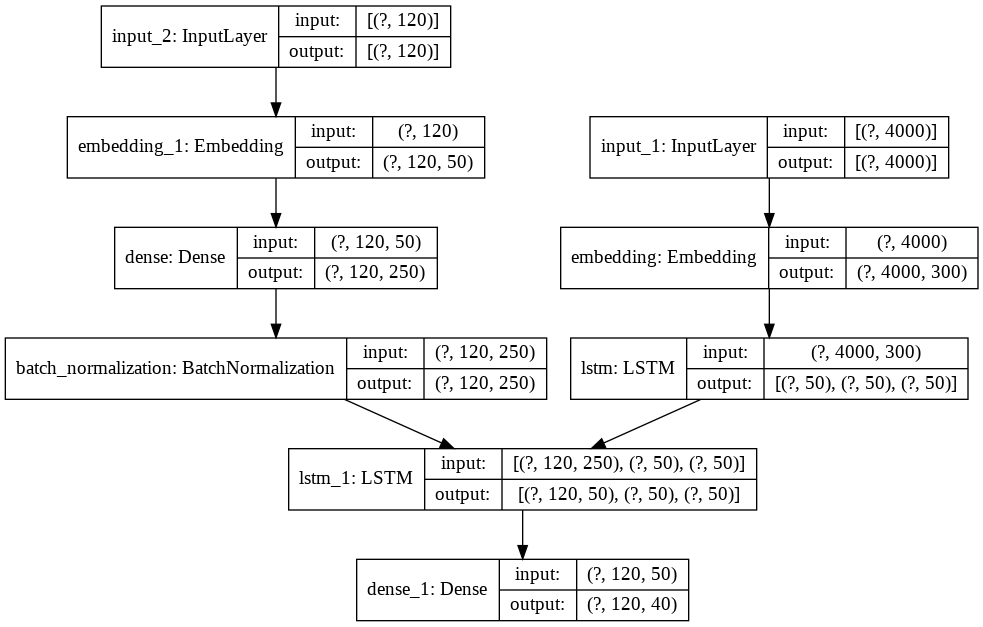

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)

In [ ]:
print(decoder_inputs.shape)
print(decoder_targets.shape)
print(encoder_inputs.shape)
print(np.expand_dims(decoder_targets, -1).shape)

(1000, 120)
(1000, 120)
(1000, 4000)
(1000, 120, 1)


In [ ]:
# decoder_inputs[:,:-1]

In [ ]:
#https://keras.io/callbacks/#modelcheckpoint
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping
checkpointer = ModelCheckpoint(filepath='model1.h5',monitor='loss',mode='min', verbose=1, save_best_only=True)
es = EarlyStopping(monitor='loss',mode='min',patience=10)

In [ ]:
batch_size

512

In [ ]:
# https://stackoverflow.com/questions/44477489/keras-difference-between-categorical-accuracy-and-sparse-categorical-accuracy
r = model.fit(
  [encoder_inputs, decoder_inputs], np.expand_dims(decoder_targets, -1),
  batch_size=batch_size,
  epochs=10,
  # validation_split=0.2,
  callbacks=[checkpointer,es]
)

Epoch 1/10
2/2 [==============================] - ETA: 0s - loss: 3.4802 - sparse_categorical_accuracy: 0.3264
Epoch 00001: loss improved from inf to 3.48016, saving model to model1.h5
2/2 [==============================] - 1s 457ms/step - loss: 3.4802 - sparse_categorical_accuracy: 0.3264
Epoch 2/10
2/2 [==============================] - ETA: 0s - loss: 2.9663 - sparse_categorical_accuracy: 0.6189
Epoch 00002: loss improved from 3.48016 to 2.96628, saving model to model1.h5
2/2 [==============================] - 1s 446ms/step - loss: 2.9663 - sparse_categorical_accuracy: 0.6189
Epoch 3/10
2/2 [==============================] - ETA: 0s - loss: 2.5429 - sparse_categorical_accuracy: 0.6211
Epoch 00003: loss improved from 2.96628 to 2.54292, saving model to model1.h5
2/2 [==============================] - 1s 444ms/step - loss: 2.5429 - sparse_categorical_accuracy: 0.6211
Epoch 4/10
2/2 [==============================] - ETA: 0s - loss: 2.2262 - sparse_categorical_accuracy: 0.6237
Epoch 00

In [ ]:
from tensorflow.keras.models import load_model

model = load_model("/content/model1.h5")

In [ ]:
# # 4-gram cumulative BLEU
# from nltk.translate.bleu_score import sentence_bleu
# reference = [['this', 'is', 'small', 'test']]
# candidate = ['this', 'is', 'a', 'test']
# score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
# print(score)

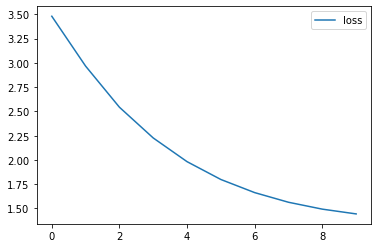

In [ ]:
plt.plot(r.history['loss'], label='loss')
# plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()


In [ ]:
# encoder_inputs.shape

In [ ]:

# import datetime
# start = datetime.datetime.now()
# encoder_model = Model(encoder_inputs_placeholder, encoder_states)
# corpus=[]
# states_value = encoder_model.predict(encoder_inputs[0:0+1])
# corpus.append(states_value[0][0])
# print("Time it took: ",datetime.datetime.now()-start)

In [ ]:
encoder_states

[<tf.Tensor 'lstm/Identity_1:0' shape=(None, 50) dtype=float32>,
 <tf.Tensor 'lstm/Identity_2:0' shape=(None, 50) dtype=float32>]

In [ ]:
# import pandas as pd
# x = pd.Series(encoder_states)
# x.to_excel('encoder_states.xlsx')
# y = list(pd.read_excel('encoder_states.xlsx')[0])
# print(y)

In [ ]:
# vectorizing all the whole coupus from encoder model

import datetime
start = datetime.datetime.now()
encoder_model = Model(encoder_inputs_placeholder, encoder_states)
corpus=[]
for i in range(len(encoder_inputs)):
  states_value = encoder_model.predict(encoder_inputs[i:i+1])
  corpus.append(states_value[0][0])
print("Time it took: ",datetime.datetime.now()-start)

Time it took:  0:01:15.041502


In [ ]:
pd.DataFrame(data=corpus).to_csv('corpus.csv')

In [ ]:
# saving to csv
df1=pd.read_csv("/content/corpus.csv")

In [ ]:
df1=df1.drop(['Unnamed: 0'],axis=1)
len(df1)

1000

In [ ]:
corpus=df1.to_numpy()
corpus.shape

(1000, 50)

# Testing 

In [ ]:
string=[]
s=input("Enter query ")
string.append(s)

Enter query best way to learn deep learning


In [ ]:
# best way to learn deep learning
# logistic regression
# difference between random forest and decision tree
# good exercises to improve the speed
# what are the exercise helps for running

In [ ]:
test_sequences=tokenizer_inputs.texts_to_sequences(string)
encoder_inputs = pad_sequences(test_sequences, maxlen=4000) #max_len_input


In [ ]:
# encoder_inputs
encoder_model = Model(encoder_inputs_placeholder, encoder_states)

In [ ]:
encoder_model.save('encoder_model.h5')

In [ ]:
from sklearn.metrics import pairwise_distances
import numpy as np
def search(query, corpus):    
    pairwise_dist = pairwise_distances(corpus, query, metric='cosine')
    indices = np.argsort(pairwise_dist.flatten())[0:10]
    pdists = np.sort(pairwise_dist.flatten())[0:10]
    df_indices = list(Questions.index[indices])
    return df_indices

In [ ]:
li=search(encoder_model.predict(encoder_inputs[0:0+1])[0],corpus)

In [ ]:
for i in li:
    print(df['clean_Body'].iloc[i]) # _Body
    print('*****************************************************************')

would like pick topic deep learning begin topic ai working way deep learning
*****************************************************************
tools practices algorithms used automated text writing example lets assume access wikipedia wikinews similar websites api would like produce article data science python believe task divided two segments first would text mining second would text building less aware text mining performed lots materials internet however amount materials related automated text building seems lower plenty articles says companies using lack details common ideas text building
*****************************************************************
trying find equivalent hinton diagrams multilayer networks plot weights training trained network somewhat similar deep srn e high number multiple weight matrices would make simultaneous plot several hinton diagrams visually confusing anyone know good way visualize weight update process recurrent networks multiple layers not found mu

In [ ]:
for i in li:
    print(df['_Body'].iloc[i]) # _Body
    print('*****************************************************************')



*****************************************************************






*****************************************************************








*****************************************************************





















*****************************************************************
























*****************************************************************


*****************************************************************






*****************************************************************







*****************************************************************











*****************************************************************






































*****************************************************************


In [ ]:
for i in li:
    print(df['clean_Body'].iloc[i]) # _Body
    print('*****************************************************************')

would like pick topic deep learning begin topic ai working way deep learning
*****************************************************************
tools practices algorithms used automated text writing example lets assume access wikipedia wikinews similar websites api would like produce article data science python believe task divided two segments first would text mining second would text building less aware text mining performed lots materials internet however amount materials related automated text building seems lower plenty articles says companies using lack details common ideas text building
*****************************************************************
trying find equivalent hinton diagrams multilayer networks plot weights training trained network somewhat similar deep srn e high number multiple weight matrices would make simultaneous plot several hinton diagrams visually confusing anyone know good way visualize weight update process recurrent networks multiple layers not found mu

In [ ]:
# for i in li:
#     print(df['clean_Body'].iloc[i]) # _Body
#     print('*****************************************************************')

In [ ]:

encoder_model = Model(encoder_inputs_placeholder, encoder_states)

decoder_state_input_h = Input(shape=(encode_dim,))
decoder_state_input_c = Input(shape=(encode_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

decoder_outputs, h, c = decoder_lstm(
  decoder_inputs_single_x,
  initial_state=decoder_states_inputs
)

decoder_states = [h, c]
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model(
  [decoder_inputs_single] + decoder_states_inputs, 
  [decoder_outputs] + decoder_states
)

idx2word_eng = {v:k for k, v in word_2_index_inputs.items()}
idx2word_trans = {v:k for k, v in word_2_index_outputs.items()}

In [ ]:
def decode_sequence(input_seq):
    print(input_seq)
    states_value = encoder_model.predict(input_seq)
    print(len(states_value))
    print(states_value[0].shape)
    print(states_value[1].shape)
    target_seq = np.zeros((1, 1))

    target_seq[0, 0] = word_2_index_outputs['<start>']

    eos = word_2_index_outputs['<end>']

    output_sentence = []
    for _ in range(max_len_target):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        if eos == idx:
            break

        word = ''
        if idx > 0:
            word = idx2word_trans[idx]
            output_sentence.append(word)

        target_seq[0, 0] = idx

        states_value = [h, c]

    return ' '.join(output_sentence)

In [ ]:
input_seqgood exercises to improve the speed

In [ ]:
while True:
  # Do some test translations
    i = np.random.choice(18000)
    input_seq = encoder_inputs[i:i+1]
    translation = decode_sequence(input_seq)
    print('-')
    print('Input:', input_texts[i])
    print('target_texts:',target_texts[i])
    print('Translation:', translation)

    ans = input("Continue? [Y/n]")
    if ans and ans.lower().startswith('n'):
        break


In [ ]:
input_seq = encoder_inputs[0:0+1]
translation = decode_sequence(input_seq)
print('-')
print('Input:', input_texts[0])
print('target_texts:',target_texts[0])
print('Translation:', translation)

In [ ]:
encoder_inputs[0:0+1]

In [ ]:
states_value = encoder_model.predict(input_seq)

In [ ]:
# states_value[0]
encoder_inputs.shape

In [ ]:
a=[]
a=map(lambda x: encoder_model.predict(encoder_inputs)[0],encoder_inputs)

In [ ]:
# b=list(a)[0]

In [ ]:
# encoder_inputs
x = [20, 30, 40, 50, 60]
y = []
y = map(lambda x: x * 5,x)

In [ ]:
list(y)

In [ ]:
# np.array(states_value[0][0])

In [ ]:
search(encoder_inputs[0:0+1],encoder_inputs)

In [ ]:
from sklearn.metrics import pairwise_distances
import numpy as np
def search(query, corpus):
#     query = process_query(query)
    # query_trans = vectorizer.transform(query)
    
    pairwise_dist = pairwise_distances(corpus, query_trans, metric='cosine')
    
    indices = np.argsort(pairwise_dist.flatten())[0:20]
    pdists = np.sort(pairwise_dist.flatten())[0:20]
    print(pdists)
    df_indices = list(Questions.index[indices])
    return df_indices

In [ ]:
encoder_inputs[0]